# Chinook Salmon

In [12]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

## Question

The Columbia River is home to hundreds of fish species, one of which is the Chinook salmon. Every year, thousands of Chinook salmon migrate to the Columbia River to breed. In the 1950s, the recorded number of visiting salmon was over 50000. Today, that number has plummeted to 1500. This drop in the salmon population is cause for alarm, as the Chinook salmon are a critical part of the river’s ecosystem.  

To combat this issue effectively, we must first understand why salmon populations are decreasing. Some hypothesize that the declining population is due to dams around the river that prevent salmon fry from escaping predatory orca whales. Others who support the dams point to climate change and warming river waters as the reason for the drop. Our goal is to determine whether warming river waters can explain the decline of the Chinook salmon population in the Columbia River.

## Model

To answer this question, we modeled the temperature of the river water and its corresponding impact on the Chinook salmon population in the region. The temperature of the river water (r) depended on the total amount of energy in the system. Two factors impacted this: solar radiation and atmospheric convection. Solar radiation put energy into the system whereas atmospheric convection took energy out of the system. This relationship is summarized by the following differential equation: 

    qin = system.qsolar 

    qout = system.h * system.area * (r - system.a) 

    drdt = (qin - qout) / (system.m * system.c) 

The parameters of the model were set using a combination of research and assumptions. For example, the amount of solar energy (qsolar) was derived from the [all-time average amount received by Seattle, WA](http://www.weatherjon.org/meteo/pages/station/climate.php?var=S) and assumed to be constant over the entire period. We made this assumption for simplification purposes. In hindsight, this was not a good choice. Keeping qsolar constant meant ignoring the fact that the amount of solar energy not only differs by time of year but by year itself. Solar radiation has been increasing year-by-year due to climate change. Ignoring this means ignoring the impact of climate change and the increasingly warmer waters. We also kept air temperature constant which was a bad choice for the same reason. These bad choices became apparent when we tried to validate our model using [real-world data](https://www.researchgate.net/figure/a-Daily-water-temperatures-on-the-Columbia-River-over-the-past-60-years-compared-with_fig6_267876853). Whereas our model of the river temperature reached a limit of 15.9°C, the real-world model continued to grow, reaching 18°C by 2010. Unfortunately, there was not enough time to go back and change our model. If we were to do so, we would consider increasing solar radiation and air temperature values. 

After modeling the temperature of the river water, we went on to model the corresponding salmon population. Our system began with 0 fry (f) and 50000 adults (a). Each year all the adults laid eggs and then died. The survival of these eggs depended on [biological probabilities](http://courses.washington.edu/fish450/Lecture%20PDFs/Survival_at_Sea.pdf) and [temperature](https://water.ca.gov/LegacyFiles/orovillerelicensing/docs/wg_study_reports_and_docs/EWG/030221/chinook-salmon-lifehistory.pdf). The remaining eggs then hatched and became adults. The survival of these adults depended on [biological probabilities](http://courses.washington.edu/fish450/Lecture%20PDFs/Survival_at_Sea.pdf). The remaining adults laid eggs and the cycle repeated. This system is summarized by the following differential equations:  

    dfdt = (a/2 * system.f_birth) * system.f_survive * heat_survive  

    dadt = (f * system.a_survive) 

For simplification purposes, many assumptions were made. For example, it was assumed that each female had only one male mate even though females can have multiple male mates. It was also assumed that the adult population came back each year even though migration periods can be anywhere between 1 and 7 years. Many factors were also ignored due to time constraints. For example, neither predators nor prey was accounted for. The impact of temperature on these groups was also not accounted for. Considering these factors in our model could have resulted in a more realistic system.

Here is a stock and flow diagram of our model:
![Stock and Flow](images/stockandflow.jpg)

### River Temperature

In [13]:
def make_system_river(dt, qsolar, h, area, a, m, c):
    """
    make_system_river creates a system to store the parameters and initial conditions for the river

    Arguments:
        dt: time step
        qsolar to c: model parameters
    """

    init = State(R=15.5)

    t_0 = 1950
    t_end = 2050 # years

    return System(
        init=init,
        t_0=t_0,
        t_end=t_end,
        dt=dt,
        qsolar=qsolar,
        h=h,
        area=area,
        a=a,
        m=m,
        c=c
    )

In [14]:
def update_func_river(state, t, system):
    """
    update_func_river  updates accepts a state and returns a new state with updated values

    Arguments:
        state (State): a state variable containing values for R
        t: time step
        system -> the system variable containing dt and the various parameters
    Arguments:
        dt: time step
        qsolar to c: model parameters
    """

    r = state.R

    qin = system.qsolar
    qout = system.h * system.area * (r - system.a)

    drdt = (qin - qout) / (system.m * system.c)

    r += drdt * system.dt

    return State(R=r)

In [15]:
def run_simulation_river(system, update_func):

    frame = TimeFrame(columns=system.init.index)

    frame.row[system.t_0] = system.init

    for t in linrange(system.t_0, system.t_end, system.dt):
        frame.row[t + system.dt] = update_func(frame.row[t], t, system)

    return frame

In [16]:
river_system = make_system_river(
    dt=1,
    qsolar=1.3403e19,
    h=1.577e9,
    area=3.2194e9,
    a=13.3,
    m=1.2266e15,
    c=4182
)

river_frame = run_simulation_river(river_system, update_func_river)

R
1950  15.500000
1951  15.935433
1952  15.939902
1953  15.939948
1954  15.939948
...         ...
2046  15.939948
2047  15.939948
2048  15.939948
2049  15.939948
2050  15.939948

[101 rows x 1 columns]

### Salmon Population

In [17]:
def make_system_fish(dt, a_survive, f_birth, f_survive):
#   death rate, birth rate, initial population of fish, survival rate of eggs due to heat, # of eggs per fish

    init_pop = State(F=0, A=50000)

    t_0 = 1950
    t_end = 2050

    return System(
        init_pop=init_pop,
        t_0=t_0,
        t_end=t_end,
        dt=dt,
        a_survive=a_survive,
        f_birth=f_birth,
        f_survive=f_survive,
    )

In [18]:
def update_func_fish(state, frame, t, system):

    f, a = state

    r = frame.iloc[t-1950]['R']

    if r <= 2:
        heat_survive = 0
    elif r > 2 and r <= 4:
        heat_survive = 0.88
    elif r > 4 and r <= 8:
        heat_survive = 0.994
    elif r > 8 and r <= 12:
        heat_survive = 0.988
    elif r > 12 and r <= 16:
        heat_survive = 0.933
    elif r > 16:
        heat_survive = 0

    dfdt = (a/2 * system.f_birth) * system.f_survive * heat_survive # number of fry
    f += dfdt * system.dt

    dadt = (f * system.a_survive) - a # number of adults
    a += dadt * system.dt

    return State(F=f, A=a)

In [19]:
def run_simulation_fish(system, update_func_fish):

    frame = TimeFrame(columns=system.init_pop.index)

    frame.row[system.t_0] = system.init_pop

    ts = linrange(system.t_0, system.t_end, system.dt)

    for t in ts:
        frame.row[t+system.dt] = update_func_fish(frame.row[t], river_frame, t, system)

    return frame

In [22]:
fish_system = make_system_fish(
    dt=1,
    a_survive=0.2,
    f_birth=4,
    f_survive=1
)

fish_frame = run_simulation_fish(fish_system, update_func_fish)

F            A
1950            0        50000
1951        93300        18660
1952       128120      25623.9
1953       175934      35186.8
1954       241592      48318.5
...           ...          ...
2046  1.13395e+18  2.26789e+17
2047  1.55713e+18  3.11427e+17
2048  2.13826e+18  4.27651e+17
2049  2.93625e+18  5.87251e+17
2050  4.03206e+18  8.06413e+17

[101 rows x 2 columns]

## Results

Using the model above we were able to plot the temperature of the river water over 100 years, starting in 1950. We then used this data to model and plot the number of adult Chinook salmon in the river over the same period. Both plots can be seen below. 

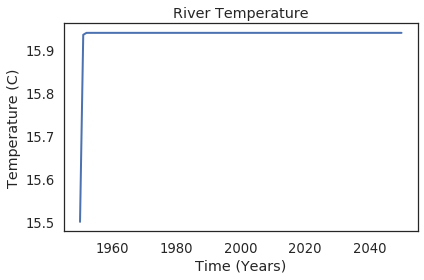

In [21]:
plot(river_frame.R)
decorate(title='River Temperature', xlabel='Time (Years)', ylabel='Temperature (C)')

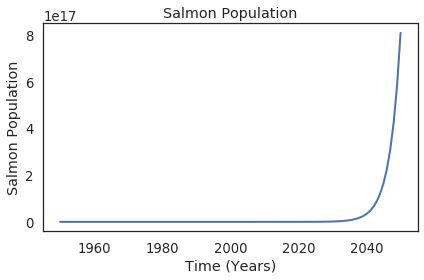

In [23]:
plot(fish_frame.A)
decorate(title='Salmon Population', xlabel='Time (Years)', ylabel='Salmon Population')

## Interpretation

Our graph presents a clear result: warming river waters cannot explain the decline of the Chinook salmon population in the Columbia River. Adult salmon populations practically skyrocketed under our model of the river temperature. This makes sense because our model of the river temperature never reached deadly conditions.  

That being said, we believe that our model is very inaccurate. When compared to [real-world data](http://courses.washington.edu/fish450/Lecture%20PDFs/Survival_at_Sea.pdf), it is clear how inaccurate our model of the river temperature is. Whereas our model of the river temperature reaches a limit of 15.9°C, the real-world model continues to grow, reaching 18°C by 2010.  

The adult fish population model is also inaccurate. The graph shows the fish population increasing exponentially as it approaches 100 years. We expected it to decline due to the water temperature, but due to inaccuracies, it barely affects the fish population model.   

There are many things missing from our model that led to these inaccuracies. The elements missing from our temperature model were probably the most significant. Our heat transfer equation didn’t really account for climate change. Because Qin stayed constant and Qout absorbed most of the energy, the water temperature reached equilibrium very quickly. In reality, Qin does not stay constant and Qout lessens over time due to warming air temperatures. Accounting for these elements would have given us more accurate results. 

Due to the inaccuracies in our temperature data, we decided to model the salmon population using data that mimicked the real-world, data that underwent a slow linear growth. The results are shown below. As you can see, the salmon population would have peaked under optimal temperatures and then quickly died out once the water became too hot.

![Fake Temperature Data](images/RiverTemperature.JPG)
![Fake Salmon Data](images/SalmonPopulation.JPG)

Here is a list of other elements that are missing from our model: 
- We chose to make our timescale equal to one year since the migration and life cycle of the chinook salmon spans for years. We were also looking at temperature over the course of a century and so it was convenient to set our timescale to one year. In hindsight, this was a poor decision because under such a large timescale, our model was not able to account for fluctuations in temperature and salmon population across the year.  

- Some things that are missing are the season, since salmon populations migrate. They leave the breeding grounds at different times of year and migrate out of them completely during the winter season.  

- Seasons also affect the average temperature of the river, and the average temperature is not accurate depiction of the temperature of the river when the salmon lay eggs, which will be during a specific season or condition. The temperature data we obtain would drastically vary from the temperatures that chinook salmon experience in their prospective seasons. 

- In addition, the adult chinook salmon is affected differently by the temperature of the water than the eggs or the fries. The eggs fare better in warmer waters, while adults are better in colder waters. Consequently, eggs hatch in summer (warm) season while adults lay the eggs in spring or fall.  

- Adults also don’t lay eggs all at the same time, some lay them during fall, and some lay them during spring. The adults all then die protecting the eggs. This would change the population of adult salmon in the Columbia river at different seasons throughout the year. Taking the average population throughout the year would not be accurate. 

- The migration periods vary from 1-7 years. We had them come back every year instead, so it may vary how many salmon come back every year to breed. 

- Females have several different male mates, so this could affect the number of eggs that are produced. 

- A carrying capacity limit. We allowed the chinook salmon population increase and did not put a limit to it; hence the population can explode, which is not true to the real world. 

- Increase/decline in predators in prey. Initially we also wanted to explore the population of plankton and orcas in relation to temperature so we could see how their population affects the salmon, since they are also affected by temperature. 

Creating this model showed us just how complex thermal environments can be. There are many factors that impact thermal systems and because of this, it is difficult to model them accurately. In order to do so, you would need to have a rich understanding of the relevant ecosystem, everything from the food web to the surrounding atmosphere. Not to mention the impact that people have. All in all, thermal systems are hard and we need more data.  